<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Final_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [ ]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt

# load data
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")

# add sorted datetime index
df['timestamp_seconds'] = df.pop('timestamp')/1000
df.set_index(pd.to_datetime(df['timestamp_seconds'], unit='s', origin='unix'), inplace=True)
df.sort_index(inplace=True)

# Define Constants
SYSTEM_ID_SELECTED = ['sys1'] # ['sys1'] or ['All']
TEST_SIZE = 0.2 # Not yet used
USE_TIME_TRANSFORMED = True 
USE_TIME_STAMP = True

# We separately process sub-sets of columns and concatenate them in a numpy array called data 
target_col = ['cpu_utilization']
numerical_transform_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
                            'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
time_col = ['timestamp_seconds']
time_transformed_cols = ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']
cols_to_encode = ['systemId', 'model_type']

#AS timestamp_seconds is appended after numerical_transform_cols are added to data
# As feature selection can be RFE thus standarize/normalize data first;
# Feature selection also cause time poition dymanic thus need be decided after all feature selection
Y_INDEX_DATA = 0 # index of target in data
X_FIRST_INDEX_DATA = 1 # first index in data for X

# time constants in seconds
hour = 60*60
day = 24*hour
week = 7*day

data_cols = []


In [ ]:
# Basic checking
# check NA and basic stats
print(f'*** There are {df.isna().sum().sum()} NA data')
df.describe()

print(df.info())
print(df.describe())

print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .tail(5))
print(df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['systemId', 'model_type', 'cpu_utilization']] .head(5))


In [62]:
#Run: check time series conditions
def plot_time_y(df):
  t = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds']].values
  t = t/60 # in minutes
  num_figs= 4
  plt.figure()

  plt.subplot(num_figs,1,1)
  plt.plot( t[1:], 'g-+')
  plt.grid()
  plt.ylabel('time in minutes')

  t = t[1:]- t[0:-1]
  plt.subplot(num_figs,1,2)
  plt.plot(t)
  plt.ylabel(f'time interval (minutes)')
  plt.grid()

  num_days = 7
  stop_index = int(num_days*24*60/5)
  plt.subplot(num_figs,1,3)
  dftmp = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  plt.plot(dftmp.index, dftmp['cpu_utilization'].values)
  plt.plot(dftmp.index[:stop_index], dftmp['cpu_utilization'].values[:stop_index], 'g-+')
  plt.ylabel('cpu_utilization')
  plt.grid()

  plt.subplot(num_figs,1,4)
  plt.plot(dftmp.index[:stop_index], dftmp['cpu_utilization'].values[:stop_index], '-+')
  plt.ylabel('cpu_utilization')
  plt.grid()

  fig = plt.gcf()
  fig.set_size_inches(18.5, num_figs*3)
  fig.suptitle(f'time series check: min interval={t.min()}, max interval={t.max()}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()

# plot y[n]-y[n-1] with decimation by D
def plot_y_decimated(D, df):
  dftmp = df[df['systemId']==SYSTEM_ID_SELECTED[0]].loc[:, ['timestamp_seconds', 'cpu_utilization']]
  L = len(dftmp)
  plt.figure()
  plt.plot( dftmp.index[1:L:D], dftmp['cpu_utilization'][1:L:D].values, '-+', label='cpu_utilization')
  plt.plot( dftmp.index[1:L:D], dftmp['cpu_utilization'][1:L:D].values - dftmp['cpu_utilization'][:L-1:D].values, 'g-+', label='delta cpu_utilization')
  plt.legend()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3)
  ax = plt.gca()
  ax.grid()



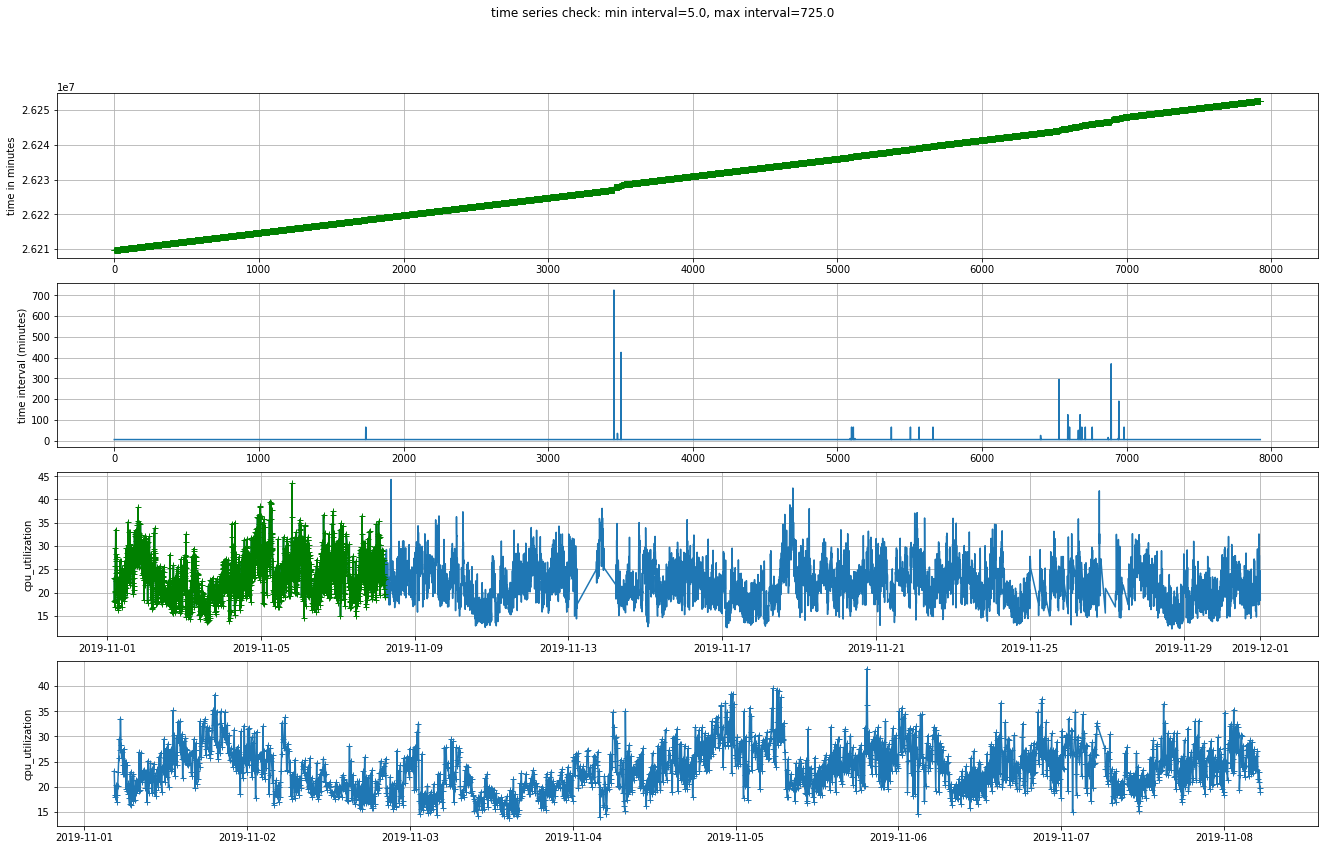

In [64]:
plot_time_y(df)  



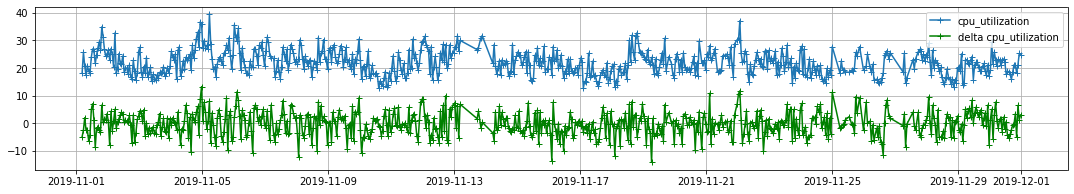

In [66]:
D = 1*12 # decimate by D*5 mins
plot_y_decimated(D, df)


It is not a strict time series data as can be shown with time interval between adjacent samples are not always same (though mostly 5 minutes).
So, it cannot be modelled with ARIMA-like methods.


## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

12 Columns

systemId - Device name

timestamp_seconds - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [70]:
# RUN to add some artificial features maybe useful for classification
# add sin/cos for day/hour
# To help finding time periodicity (hourly/daily/weekly/monthly/yearly), 
#    add additional features like "time of day/week" by appling cos and sin to timestamp_seconds 
df['Hour_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Hour_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / hour))
df['Day_Sin'] = np.sin(df['timestamp_seconds'] * (2 * np.pi / day))
df['Day_Cos'] = np.cos(df['timestamp_seconds'] * (2 * np.pi / day))
week_offset = 3*day # as epoch 0 is Thursday 1970-01-01, and leap seconds 23:59:60
df['Week_Sin'] = np.sin((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))
df['Week_Cos'] = np.cos((df['timestamp_seconds']+week_offset) * (2 * np.pi / week))

print(df.shape, df.index.shape, df.columns)


(175505, 18) (175505,) Index(['systemId', 'model_type', 'cpu_utilization', 'read_cache_miss',
       'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput',
       'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds',
       'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos'],
      dtype='object')


In [ ]:
# plot utilities

def plot_corr(df, systemId_selected):
  import seaborn as sns
  if systemId_selected[0] == 'All':
    df_tmp = df
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]]
  sns.set_theme(style="white")
  # Compute the correlation matrix
  corr = df_tmp.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(15, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  f.suptitle(f'systemId {systemId_selected[0]}')

  
# plot histogram of systemId_selected
def plot_df_hist(df_tmp, systemId_selected, title_str, cols, bins):
  if systemId_selected[0] != 'All':
    df_tmp = df_tmp[df_tmp['systemId']==systemId_selected[0]]
  df_tmp = df_tmp[cols]
  df_tmp.hist(bins=bins)
  fig = plt.gcf()
  fig.set_size_inches(18, 8)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.tight_layout()
  fig.subplots_adjust(top=0.9)

# utility hist2d plot xcols against target ycol
def hist2d_plot(df_temp, systemId, xcols, ycol, xbins, ybins, vmax):
  print(f"hist2d_plot 1 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  if systemId != 'All': 
    df_temp = df[df['systemId']==systemId[0]]
  print(f"hist2d_plot 2 Initial address of df_temp: {id(df_temp)}, shape={df_temp.shape}")
  print(df_temp.shape)
  len_x = len(xcols)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if x_index == len_x:
        break
      plt.subplot(num_rows, num_cols, x_index+1)
      plt.hist2d(df_temp[xcols[x_index]], df_temp[ycol], bins=[xbins, ybins], vmax=vmax) #
      plt.colorbar()
      plt.xlabel(xcols[x_index])
      plt.ylabel(ycol)
      x_index = x_index + 1
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()


In [ ]:
# RUN: plot hist
# Conclusion: a few columns are far from Gaussian distribution
plot_corr(df, SYSTEM_ID_SELECTED)
title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

The histograms show that we need apply normalization and power transformation


In [ ]:
#Plot hist2d: xcols against target ycol
vmax = 100; xbins = 50; ybins = 50
ycol = 'cpu_utilization'
xcols_group = [
  ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops'],
  ['read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
  ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']]
for xcols in xcols_group:
  hist2d_plot(df, SYSTEM_ID_SELECTED, xcols, ycol, xbins, ybins, vmax)

# Start preprocessing data: transform to Gaussian, scale, label ategorical featurures and one-hot encode;




In [72]:
# All pre-processing functions
# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def get_target_for_transform(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  if print_flag:
    print(f'*** Inside get_target_for_transform(): df_tmp.shape={df_tmp.shape}')
  # Start Transformation
  data = df_tmp.values
  return data

# Transform to make data more Gaussian-like 
# Standarize to make close Norml(0, 1)
# Only to numerical_transform_cols, not for timestamp, categoricals
def transform_features(df, systemId_selected, numerical_transform_cols, print_flag=False):
  from sklearn.preprocessing import PowerTransformer
  #from sklearn.preprocessing import QuantileTransformer
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  # Start Transformation
  data = df_tmp.values
  power = PowerTransformer(method='box-cox', standardize=True)
  data = power.fit_transform(data)
  if print_flag:
    print(f'*** Inside transform_features(): df_tmp.shape={df_tmp.shape}')
    print(f'  transform_features: {power.get_params(deep=True)}')
    print(f'  power.lambdas_: {power.lambdas_}')
  return data, power

# RUN: LabelEncoder + OneHotEncoder for categorical columns
# return np.array oflabel encoded data and encoders
def label_encode(df_in, systemId_selected, cols_to_encode, print_flag=False):
  from sklearn.preprocessing import LabelEncoder
  from sklearn.preprocessing import OneHotEncoder
  if systemId_selected[0] == 'All':
    df = df_in
  else:  
    df = df_in[df_in['systemId']==systemId_selected[0]]
  print(f'inside label_encode: systemId={systemId_selected}, df shape={df.shape}')
  first_col = True
  label_encoders = []
  my_onehot_encoders = []
  for col in cols_to_encode:
    label_encoder = LabelEncoder()
    X = df[col].values
    X = label_encoder.fit_transform(X)
    label_encoders.append({col:label_encoder})
    X = X.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    X = onehot_encoder.fit_transform(X)
    if print_flag:
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, X.shape={X.shape}')
      print(f'******Inside label_encode: just after my_OneHotEncoder: col={col}, onehot_encoder={onehot_encoder}')
    if first_col:
      data = X
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
      first_col = False
    else:        
      data = np.concatenate((data, X), axis=1)
      #print(f'first_col={first_col}, col={col}, X.shape={X.shape}, data.shape={data.shape}')
  return data, label_encoders, my_onehot_encoders 

def minmax_scaler_time(df, systemId_selected, cols):
  from sklearn.preprocessing import MinMaxScaler
  if systemId_selected[0] == 'All':
    df_tmp = df[cols].values
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][cols].values
  minmax_scaler = MinMaxScaler()
  df_tmp = minmax_scaler.fit_transform(df_tmp)
  return df_tmp

Compare hists of each single systemId ('sys1' vs 'sys2', etc) and single systemId with hist of all systemIds 'All' case:
1. each systemId has different hist patterns
2. Hour_Sin and Hour_Cos show a pattern at certain times per hour


# Apply transforms and extract X, Y, x_cols;


In [73]:
# RUN: apply transforms to df and extract X, Y, x_cols;

# Step 1: transform AND standarization FOR numerical_transform_cols
# Step 1.1: transform target Y
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 
from sklearn.preprocessing import PowerTransformer

data_cols = []
data = get_target_for_transform(df, SYSTEM_ID_SELECTED, target_col)
target_transformer = PowerTransformer(method='box-cox', standardize=True)
data = target_transformer.fit_transform(data)
data_cols = data_cols + target_col

print(f'After Y PowerTransformer, data shape={data.shape}, target_col len = {len(target_col)}, data_cols={len(data_cols)}')
print(f'  target_transformer.get_params = : {target_transformer.get_params(deep=True)}')
print(f'  target_transformer.lambdas_= {target_transformer.lambdas_}')

# Step 1.2: transform AND standarization FOR numerical_transform_cols
# MUST first use numerical_transform_cols THEN use cols_to_encode
# MUST NOT transform timestamp_seconds !!! 

print(f'Before X numericals transformation:')
print(f'  data shape = {data.shape}')
print(f'  len of numerical_transform_cols = {len(numerical_transform_cols)}')
data_new, numerical_X_transformer = transform_features(df, SYSTEM_ID_SELECTED, numerical_transform_cols)
data_cols = data_cols + numerical_transform_cols
data = np.concatenate((data, data_new), axis=1)
print(f'After X numericals transformation:')
print(f'  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')


# process timestamp_seconds
if USE_TIME_STAMP:
  print(f'Before add new column {time_col}:\n  data shape={data.shape},\n  len time_col={len(time_col)}')
  data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_col)
  data_cols = data_cols + time_col
  data = np.concatenate((data, data_new), axis=1)
  print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')

# RUN: MinMax timestamp_seconds, not StandardScaler
# timestamp_seconds will be mapped to data[:,9] AND X[:,8]
if USE_TIME_TRANSFORMED:
  data_cols = data_cols + time_transformed_cols
  data_new = minmax_scaler_time(df, SYSTEM_ID_SELECTED, time_transformed_cols)
  print(f'Before add {len(time_transformed_cols)} columns {time_transformed_cols}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
  data = np.concatenate((data, data_new), axis=1)
  print(f'After add time_transformed_cols:\n  data shape={data.shape},\n  data_cols ={data_cols}')


# Add label encoder categorical columns (model_type only) (sysemId)
# Note: This is only useful is model all systemIds together;
# WARNING: only run once to avoid add the same columns more than 1 times

data_new, label_encoders, my_onehot_encoders = label_encode(df, SYSTEM_ID_SELECTED, cols_to_encode)
print(f'Before add {len(cols_to_encode)} columns {cols_to_encode}:\n  data shape={data.shape},\n  data_new shape={data_new.shape}')
data = np.concatenate((data, data_new), axis=1)
data_cols = data_cols + cols_to_encode

print(f'After concatenate:\n  data shape={data.shape}')
print(f'  data_cols len={len(data_cols)},\n  data_cols={data_cols}')

X = data[:, X_FIRST_INDEX_DATA:]
Y = data[:, Y_INDEX_DATA]
x_cols = data_cols[1:]


After Y PowerTransformer, data shape=(7926, 1), target_col len = 1, data_cols=1
  target_transformer.get_params = : {'copy': True, 'method': 'box-cox', 'standardize': True}
  target_transformer.lambdas_= [0.07711959]
Before X numericals transformation:
  data shape = (7926, 1)
  len of numerical_transform_cols = 8
After X numericals transformation:
  data shape=(7926, 9)
  data_cols len=9,
  data_cols=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
Before add new column ['timestamp_seconds']:
  data shape=(7926, 9),
  len time_col=1
After add ['timestamp_seconds']:
  data shape=(7926, 10),
  len data_cols=10
Before add 6 columns ['Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos']:
  data shape=(7926, 10),
  data_new shape=(7926, 6)
After add time_transformed_cols:
  data shape=(7926, 16),
  data_cols =['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read

In [97]:
# Run to check results in good shape 
dftemp = df[df['systemId']==SYSTEM_ID_SELECTED[0]]
print(f' df with {SYSTEM_ID_SELECTED} shape = {dftemp.shape}\n')
del dftemp
print(f' data.shape = {data.shape}, len(data_cols) = {len(data_cols)}\n')
print(f' len(x_cols)={len(x_cols)}, X.shape = {X.shape}, Y.shape = {Y.shape}\n')
print(f' data_cols = {data_cols}, \n x_cols = {x_cols}\n' )


 df with ['sys1'] shape = (7926, 18)

 data.shape = (7926, 18), len(data_cols) = 18

 len(x_cols)=17, X.shape = (7926, 17), Y.shape = (7926,)

 data_cols = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type'], 
 x_cols = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type']



After add ['timestamp_seconds']:
  data shape=(7926, 18),
  len data_cols=18


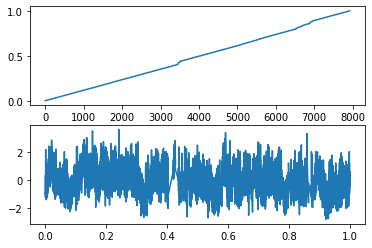

In [77]:
print(f'After add {time_col}:\n  data shape={data.shape},\n  len data_cols={len(data_cols)}')
plt.subplot(2,1,1)
plt.plot(data[:, data_cols.index('timestamp_seconds')])
plt.subplot(2,1,2)
plt.plot(data[:, data_cols.index('timestamp_seconds')], data[:, 0])


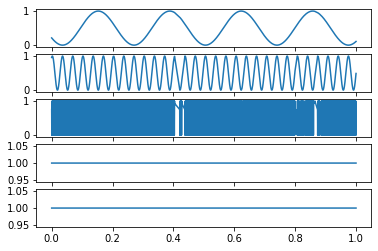

In [78]:
# check time transformations are all right
plt.figure()
index_to_plots = [1,3,5,7,8]
L = len(index_to_plots)
for k in range(L):
  plt.subplot(L,1,k+1)
  plt.plot(data[:, data_cols.index('timestamp_seconds')], data[:, data_cols.index('timestamp_seconds') + index_to_plots[k]],)


In [ ]:
# Compare hist before/after transformation/scaling 
# Before transformation: hist
title_str = 'Before transformation!'
plot_df_hist(df, SYSTEM_ID_SELECTED, title_str, df.columns, 30)
#NOTE: Hour_Sin AND Hour_Cos have only 7 distinct bins at [0, 30, 60, 90, -30, -60, -90] degress as 
# as sampling perid=5 minutes, thus 2pi*5min/60min=pi/6=30degree

# After transformation: hist
title_str = 'After transformation!'
data_df = pd.DataFrame(data, columns=data_cols)
plot_df_hist(data_df, ['All'], title_str, data_df.columns, 30)
del data_df

Feature selection:
1. correlation based
2. L1 norm
3. p-value

In [ ]:
# RUN: feature selection based on correlation  
# NOTE: this is done separately for each of systemId, not for all systemIds altogether
#label encoder for model
def select_feature_by_correlation(data, data_cols, target_col, corr_threshold):
  df = pd.DataFrame(data, columns=data_cols)
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
      if corr.iloc[i,j] >= corr_threshold:
        columns[j] = False
  selected_columns = df.columns[columns]
  removed_columns = [x for x in df.columns if x not in selected_columns]

  print(f'df shape={df.shape}; corr shape={corr.shape};')
  print(f'df.columns={df.columns}')
  print(f'columns={columns}')
  print(f'selected_columns={selected_columns}')
  print(f'removed_columns={removed_columns}')
  return selected_columns, removed_columns, corr



In [ ]:
# RUN: feature selection based on correlation  
CORR_THRESHOLD_FEATURE_SELECTION = 0.8;
pd.set_option('display.max_columns', None)

#corr of X
selected_columns, removed_columns, corr_X = select_feature_by_correlation(X, x_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    


In [ ]:
# corr of data
_, _, corr_data = select_feature_by_correlation(data, data_cols, target_col, CORR_THRESHOLD_FEATURE_SELECTION)    

In [ ]:
corr_X

In [ ]:
# plot 'read_throughput', 'read_cache_miss'
cols_correlated = ['read_throughput', 'read_cache_miss', 'read_iops', 'write_iops']
cols_correlated_index = [data_cols.index(x) for x in cols_correlated]

print(len(data_cols), data.shape)
print(cols_correlated_index, data_cols)
plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[1]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[2]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[0]], data[:, cols_correlated_index[3]], '+')

plt.figure()
plt.plot(data[:, cols_correlated_index[2]], data[:, cols_correlated_index[3]], '+')


In [ ]:
# list all sklearn allowed scoring 
import sklearn
sorted(sklearn.metrics.SCORERS.keys())


In [ ]:
# make a regression prediction with an RFE pipeline
# Observation: Features are selected almost according to their correlation with target
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# create pipeline
for num_features in range(2,17):
  rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=num_features)
  #model = DecisionTreeRegressor()
  #pipeline = Pipeline(steps=[('s',rfe),('m',model)])
  # fit the model on all available data
  #pipeline.fit(X, Y)
  rfe.fit(X, Y)
  scores = rfe.score(X, Y)
  selected_features = rfe.get_support(indices=True)
  print(num_features, selected_features, scores)
  selected_feature_str = [x_cols[x] for x in selected_features]
  print(f'  {selected_feature_str}')
  #print(f"  {corr_data.loc[selected_feature_str, target_col[0]]}")


In [ ]:
# Start RFE feature selection; 
# Input: X, Y, num_features_to_select
NUM_SPLITS = 10

num_features_to_select = [12,13]
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(num_features_to_select[0], num_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = DecisionTreeRegressor()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  kfold = KFold(n_splits = NUM_SPLITS) # shuffle=False
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', 
                           cv=kfold, n_jobs=-1, error_score='raise')
  return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
  #print(model.support_, model.ranking_)
  print(model)
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


Observation:
1. read_throughput and read_cache_miss are highly correlated (0.862791);
2. model_type and systemId are unrelated in case of single case systemId
3. timestamps not contribute much
4. transfomred times have some correlation with a few columns



In [ ]:
removed_columns = removed_columns + ['model_type', 'systemId']
removed_columns

In [ ]:
def remove_data_columns(data, data_cols, removed_columns):
  data_index_remove = [data_cols.index(x) for x in removed_columns]
  print(f'data_index_remove = {data_index_remove}')
  data = np.delete(data, data_index_remove, axis=1)
  data_cols_updated = [ x for x in data_cols if x not in removed_columns]
  print(data.shape, len(data_cols_updated), data_cols_updated)
  return data_cols_updated, data  


In [ ]:
# WARNING: only run this ONCE
data_cols, data = remove_data_columns(data, data_cols, removed_columns)
TIMESTAMP_INDEX_AFTER_FS = data_cols.index('timestamp_seconds')

**Observation** 
After comparison Correlation plots of two cases:
-- Case_SINGLE: Only extract a single systemId (here 'sys1') case; 
-- Case_ALL:  Use all systemIds as a whole;

Conclusion:
1. timestamp_seconds has low correlation with all the rest features; and is less useful directly;
2. Day_Cos and Day_Sin have good correlation with a few columns and shall help prediction;


Case_SINGLE clearly exposes a larger nuber of columns having high correlations with the target 'cpu_utilization' than  that of Case_ALL. 

1.1 columns having good correlation with 'cpu_utilization':
Case_SINGLE: ['write_throughput', 'write_iops', 'read_cache_miss', 'read_throughput', 'read_iops', 'write_cache_miss']

Case_ALL: ['read_throughput', 'read_cache_miss'] 
['write_cache_miss',  'read_iops', 'write_throughput', 'write_iosz' ]

1.1 columns having good correlation with Day_sin:  
Case_SINGLE ['write_cache_miss', 'read_iops', 'write_iosz' ]
Case_ALL: None

1.2 Day_Cos has good correlation with 2 columns:
Case_SINGLE: ['write_iops', 'read_iosz']
Case_ALL: None





In [ ]:
# check outliers; conclusion: no apparent outliers
df_stat = df.describe().T
df_stat['50% to 75%'] = (df_stat['50%']/df_stat['75%'])
df_stat['max to 75%'] = (df_stat['max']/df_stat['75%'])


In [ ]:
# RUN: backwardElimination
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    print(f'x={x[:2,:]}')
    print(f'Y={Y[:2]}')
    print(f'len(x[0]) = {len(x[0])}')
    print(f'x shape = {x.shape}')

    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
        print(f'**** backwardElimination i={i}, p-values={regressor_OLS.pvalues}')
        print(f'inside loop: x shape = {x.shape}')
                    
    print(regressor_OLS.summary())
    return x, columns


In [ ]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(x_in, y_in, SL, selected_columns)

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
features = [['systemId', 'read_iops', 'read_cache_miss'],
            ['systemId', 'write_throughput', 'write_iosz'],
            ['systemId', 'write_cache_miss', 'write_iops']]



In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
metrics = []
metrics_sum = dftemp.groupby('systemId').resample('W').sum()
metrics_std = dftemp.groupby('systemId').resample('W').std()
metrics_std = dftemp.groupby('systemId').resample('W').median()


In [ ]:
type(metrics_sum.index.values)



In [ ]:
print(metrics_sum.index.values.shape)
print(type(metrics_sum.index.values))
print(type(metrics_sum.index.values[0]))
print(type(metrics_sum.index.values[0][0]))

print(metrics_sum.index.values.shape)
print(metrics_sum.index.values[0])
print(metrics_sum.index.values[:10][0])

     


In [ ]:
print(metrics_sum.index.values[:10][:][:][0])


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
metrics = []
metrics.append(dftemp.groupby('systemId').resample('W').sum())
metrics.append(dftemp.groupby('systemId').resample('W').std())
metrics.append(dftemp.groupby('systemId').resample('W').median())


In [ ]:
metrics[2]['read_iops'].plot(subplots=True)

In [ ]:
metrics[2].index.names
 



In [ ]:
metrics_sum

In [ ]:
print(f'{type(dfx)}, \n {df.shape}, \n {dfx.shape}, \n, {dfx.columns}, \n, {dfx.index}')


In [ ]:
print(f'{dfx}')

In [ ]:
df[df['systemId'] =='sys1']['cpu_utilization']

In [ ]:
dfx.loc['sys1']

In [ ]:
df[df['systemId'] =='sys1']

In [ ]:

dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>5: 
    break

  print(f'\n\n ****** ct={ct}, {group_name} , shape={df_group.shape}****') 
  #print(df_group.index)
  #print(df_group.head())

  stat = df_group.resample('W', origin='start').median()
  # rename columns
  stat.columns = [group_name+'_read_iops_median', group_name+'_read_cache_miss_median']
  #reset index to get grouped columns back
  #stat = stat.reset_index()

  print(f'\n ****** {group_name} mean, shape={stat.shape}, stat type ={type(stat)}****') 
  print(stat)

  if ct==1:
    df_merged = stat
  else:        
    df_merged = pd.concat([df_merged, stat], axis=1) #ignore_index=True, 

  print(f'\n ****** {group_name} mean, df_merged shape={df_merged.shape}, df_merged columns ={df_merged.columns}****') 
  print(f'**************** df_merged=\n{df_merged}')


In [ ]:
df_merged

In [ ]:
features = ['systemId','read_iops', 'read_cache_miss'] #, 'write_throughput', 'write_iosz', 'write_cache_miss', 'write_iops']
dftemp = df[features]
df_grouped = dftemp.groupby('systemId')


In [ ]:
df_grouped.head()

In [ ]:
type(df_grouped)

In [ ]:
df_grouped[df_grouped['systemId'] == 'sys1']

In [ ]:
len(df_grouped)


In [ ]:
for x in df_grouped:
  print(x)

In [ ]:
def make_metrics_std_median(X, x_cols, std_median_cols, print_flag=False):
  print(f' *** Inside make_metrics_std_median(): systemId={systemId_selected}, df shape={df.shape}')



  df1[f] = df1[f].rolling(window=Window_Length).mean()

# Run to add metrics
std_median_cols = ['read_iops', 'read_cache_miss']
make_metrics_std_median(X, x_cols, std_median_cols, True)


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)

In [ ]:
print(X.shape, len(x_cols))


In [ ]:

# normalize, average, and plot
def plot_columns_average(df, AVERAGE_METHOD, Window_Length):
  df1 = df[df['systemId']=='sys1']

  start_hour = 24*1+15;
  interval_hour= 24*20 + 10
  start = int(start_hour*hour/(5*60))
  stop = int((start_hour + interval_hour)*hour/(5*60))

  for f in cols_to_avg:
    if AVERAGE_METHOD == 'rolling_moving_average':
      df1[f] = df1[f].rolling(window=Window_Length).mean()
    elif AVERAGE_METHOD == 'exponential_moving_average':
      df1[f] = df1[f].ewm(span=Window_Length, adjust=False).mean()
    elif AVERAGE_METHOD == 'cumulative_average': 
      df1[f] = df1[f].expanding(min_periods=Window_Length, adjust=False).mean()
    else:
      raise ValueError(f'AVERAGE_METHOD ={AVERAGE_METHOD} is not implemented!')
        
Window_Length = int(2*60/5) 

AVERAGE_METHOD_LIST = ['rolling_moving_average', 'exponential_moving_average', 'cumulative_average']
AVERAGE_METHOD = AVERAGE_METHOD_LIST[1] 
plot_columns_average(df, AVERAGE_METHOD, Window_Length)


In [ ]:
group = group.sort_values(by='timestamp_seconds')
group.head(8)tmp = group.rolling(2).mean()
tmp.head(8)

group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

In [ ]:
# fft plot TODO: for time ordered and single systemId 
def plot_fft(df_in, col_choice):
  import tensorflow as tf
  df = df_in[df_in['systemId']==SYSTEM_ID_SELECTED[0]]
  fft = tf.signal.rfft(df[col_choice])
  f_per_dataset = np.arange(0, len(fft))
  print(f'df.shape={df.shape}, fft.shape={fft.shape}')
  n_samples_h = len(df[col_choice])
  plt.plot(f_per_dataset, np.abs(fft), '-+')
  #plt.xscale('log')
  plt.ylim(0, np.mean(np.abs(fft))*10)
  plt.xlim([0.1, max(plt.xlim())])
  _ = plt.xlabel('Frequency (log scale)')
  plt.grid()


In [ ]:
plot_fft(df, 'cpu_utilization')


In [ ]:
plot_fft(df, 'read_throughput')

In [ ]:
plot_fft(df, 'write_throughput')

In [ ]:
plot_fft(df, 'Hour_Cos')


In [ ]:
plot_fft(df, 'Day_Cos')
7966/24/12

In [ ]:
plot_fft(df, 'Week_Cos')


In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [98]:
data.shape

(7926, 18)

## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

The effect of time in this data set is not clear as shown be correlation of time with target.
Thus we can use KFold for cross-validation.


In [ ]:
# Use LinearRegression for regression, DecisionTreeRegressor for feature selection
# explore the number of selected features for RFE
# Try Ridge, Lasso, ElasticNet for regularization and feature selection
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]
ridge_alpha = 0.1 # larger alpha stronger regularisation
lasso_alpha = 0.1 # larger alpha stronger regularisation

from enum import Enum
class LRModel(Enum):
   LR = 1
   RIDGE = 2
   LASSO = 3
   ELASTICNET = 4


# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models(model_choice):
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		#rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
    if model_choice == LRModel.LR:
  		model = LinearRegression()
    elif model_choice == LRModel.RIDGE:
  		model = Ridge()
    elif model_choice == LRModel.LASSO:
  		model = Lasso()
    elif model_choice == LRModel.ELASTICNET:
  		model = ElasticNet()
    else:
      print("Unexpected arg for LR model")
      raise


		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores


# define dataset
X, y = get_dataset(X, Y)


In [ ]:
# get the models to evaluate
models = get_models(LRModel.Ridge)

# KFOLD Cross-validation
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


In [ ]:
# Time-series split with time continuity kept
# evaluate the models and store results

TRAIN_FRACTION = 0.7
L_train = int(len(Y)*TRAIN_FRACTION)

X_train = X[:L_train, :]
Y_train = Y[:L_train]
X_test = X[L_train:, :]
Y_test = Y[L_train:]

results, names = list(), list()
model.fit(X_train, Y_train)
predicted = model.predict(X_test, Y_test)

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# DNN regression
NUM_SPLITS = 5
NUM_EPOCHS = 1
BATCH_SIZE = 10

# Regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

Y = data[:, Y_INDEX_DATA]
X = data[:, X_FIRST_INDEX_DATA:]

# define base model
def baseline_model():
	model = Sequential()
	model.add(Dense(18, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# Step: evaluate model with standardized dataset
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=2)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits = NUM_SPLITS, shuffle=False)
print(f'X shape={X.shape}, Y shape = {Y.shape}')
results = cross_val_score(pipeline, X, Y, cv=kfold)
print(f'results of cross_val_score = {results}')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [ ]:
# DNN/MLP: get predicted values
from sklearn.model_selection import cross_val_predict
# TRY this also
#from sklearn import linear_model

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#results = cross_val_score(pipeline, X, Y, cv=kfold)
predicted = cross_val_predict(pipeline, X, Y, cv=kfold)
# method='predict', 
# X: array-like of shape (n_samples, n_features)
# Returns: When method is ‘predict’: (n_samples,)

fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
plt.show()

In [83]:
print(x_cols.index('timestamp_seconds'))


8


In [ ]:
# plot against time IN transformed/scaled version
def plot_prediction_time(start, stop, X, Y, predicted):
  num_cols = 3
  plt.subplot(num_cols, 1, 1)
  plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1], Y[start:stop], 'b-+', label='rea target')
  #plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1], ( predicted[start:stop]), 'g-o', label='predicted target')
  plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1], (Y[start:stop] - predicted[start:stop]), 'g-o', label='error')
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 2)
  plt.plot(data[start:stop, TIMESTAMP_INDEX_AFTER_FS], (Y[start:stop] - predicted[start:stop])/(Y[start:stop]), 'r-*', label='error/real')
  plt.ylim(0, 1)
  plt.ylabel('scaled target')
  plt.xlabel('scaled time')
  plt.grid(True)
  plt.legend()

  plt.subplot(num_cols, 1, 3)
  #plt.plot(X[start:stop, TIMESTAMP_INDEX_AFTER_FS-1])
  plt.hist((Y[start:stop] - predicted[start:stop])/(Y[start:stop]), bins=100)
  plt.ylabel('scaled time')

  fig = plt.gcf()
  fig.set_size_inches(22.5, num_cols*3)


# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values


In [ ]:
start= 1000 #int(0*24*60/5)
stop = 1111 #len(Y) #int(1*24*60/5)
plot_prediction_time(start, stop, X, Y, predicted)



In [ ]:
start=100; stop=110
print(Y[start:stop], '\n',predicted[start:stop], '\n',
      Y[start:stop]- predicted[start:stop], '\n', (Y[start:stop]- predicted[start:stop])/Y[start:stop])


In [ ]:
plt.plot(Y, predicted, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )

# RUN: inverse_transform of predicted target 
y_hat = target_transformer.inverse_transform( predicted.reshape(predicted.shape[0], 1) )
print(predicted.shape, y_hat.shape, type(y_hat))


In [ ]:
# RUN: inverse_transform TRUE target transformed
y_real_inverse_transfomred = target_transformer.inverse_transform( Y.reshape(Y.shape[0], 1) )
print(Y.shape, y_real_inverse_transfomred.shape, type(y_real_inverse_transfomred))


In [ ]:
plt.plot(y_real, y_real_inverse_transfomred, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)

In [ ]:
plt.plot(y_real_inverse_transfomred, y_hat, '+')
plt.grid()
fig = plt.gcf()
fig.set_size_inches(22.5, 5)


NameError: ignored

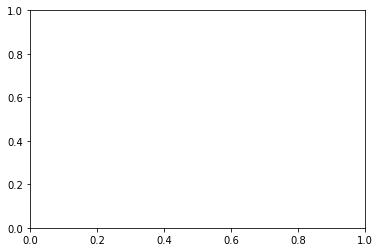

In [85]:
# TODO: get real time in timedate
#plot inverse transformed y_hat against time
fig, ax = plt.subplots()
start= int(0*24*60/5)
stop = int(0.2*24*60/5)

ax.plot(X[:, x_cols.index('timestamp_seconds')][start:stop], y_real[start:stop], 'b-+', label='real')
ax.plot(X[:, x_cols.index('timestamp_seconds')][start:stop], y_hat[:, 0][start:stop], 'g-o', label='predicted')
ax.set_xlabel('scaled time')
ax.set_ylabel('Predicted')
ax.grid()
ax.legend()
fig = plt.gcf()
fig.set_size_inches(22.5, 3)
plt.show()


In [ ]:
# Run this after Standardarization
# Add nonlinear transformation of features
df['rw_cache_miss_ratio'] = df['read_cache_miss'] / df['write_cache_miss']
df['rw_iops_ratio'] = df['read_iops'] / df['write_iops']
df['rw_throughput_ratio'] = df['read_throughput'] / df['write_throughput']
df['rw_iosz_ratio'] = df['read_iosz'] / df['write_iosz']

df['rw_cache_miss_diff'] = df['read_cache_miss'] - df['write_cache_miss']
df['rw_iops_diff'] = df['read_iops'] - df['write_iops']
df['rw_throughput_diff'] = df['read_throughput'] - df['write_throughput']
df['rw_iosz_diff'] = df['read_iosz'] - df['write_iosz']

In [ ]:
# remove cols_remove from cols;
# divide cols into array of lists of size W 
def split_columns(cols, cols_remove, W):
  for col in cols_remove:
    cols.remove(col)
  L = len(cols)
  R = int(L/W)
  x1 = list(np.array(cols[:R*W]).reshape(R,W))
  x2 = cols[R*W:]
  x1.append(x2)
  return x1

In [ ]:
# RUN: pairplotr VERY SLOW for larger number of features! !!
def pairplot(df, systemId_selected, cols, title_str):
  if len(systemId_selected)>0:
    df = df[df['systemId']==systemId_selected]
  sns.pairplot(df[cols], corner=True)
  fig = plt.gcf()
  fig.set_size_inches(15.5, 3*2)
  fig.suptitle(f'{title_str}, systemId {systemId_selected[0]}')
  plt.show()

In [ ]:
systemId = 'sys1'
cols = list(df.columns.values)
cols_remove = ['timestamp_seconds', 'systemId', 'model_type']
W = 4
cols_groups = split_columns(cols, cols_remove, W)
print(f'cols_groups={cols_groups}')
title_str = 'Before Transformation'

for col_subset in cols_groups:
  pairplot(df, systemId, col_subset, title_str)

In [ ]:
print(f' data.shape={data.shape}, data_cols len={len(data_cols)}\n data_cols={data_cols}')


In [ ]:

fig, ax = plt.subplots()
ax.scatter(y_real, y_hat[:, 0])
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.show()
predicted.shape


Finished regression here

In [ ]:
# Use LinearRegression for regression, LinearRegression for feature selection
# DecisionTreeRegressor for feature selection ??? TODO
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor



from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		#rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
		model = LinearRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=10, shuffle=False, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
pyplot.grid()

In [ ]:
import sklearn.metrics as skmetrics
sorted(skmetrics.SCORERS.keys())


## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

In [99]:
print(X.shape, Y.shape)
print(data_cols, '\n', x_cols)
print(type(X))

(7926, 17) (7926,)
['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type'] 
 ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'timestamp_seconds', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin', 'Hour_Cos', 'systemId', 'model_type']
<class 'numpy.ndarray'>


In [100]:
target_threshold = target_transformer.transform([[20]])
target_threshold = target_threshold[0]

In [101]:
f = lambda x: x>target_threshold
Y_cat = f(Y)*1


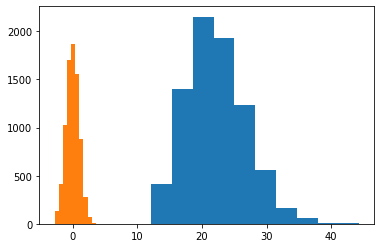

In [110]:
# Get orignal target w/o transformation from df
def get_target(df, systemId_selected, numerical_transform_cols):
  if systemId_selected[0] == 'All':
    df_tmp = df[numerical_transform_cols]
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]][numerical_transform_cols]
  return df_tmp.values

y_real = get_target(df, SYSTEM_ID_SELECTED, 'cpu_utilization' )
_= plt.hist(y_real)


_=plt.hist(Y)

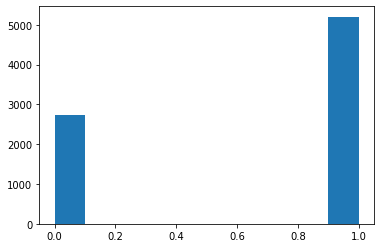

In [108]:
f1 = lambda x: x>20
y_real_cat = f1(y_real)*1
_= plt.hist(y_real_cat)

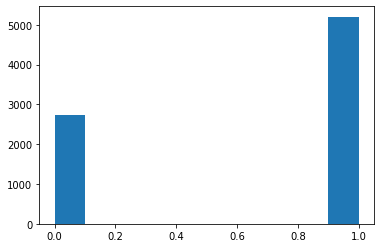

In [103]:
_= plt.hist(Y_cat)

In [ ]:
# Use LogisticRegression for classification, DecisionTreeClassifier for feature selection

# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = LogisticRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

In [ ]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

In [ ]:
# Use RandomForestClassifier for classification, DecisionTreeClassifier for feature selection
# TODO: add f1-score for biased classification
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from matplotlib import pyplot

n_features_to_select = [2, len(x_cols)]

# get the dataset
def get_dataset(X, Y):
	X, y = X, Y
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(n_features_to_select[0], n_features_to_select[1]):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = RandomForestClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset(X, Y_cat)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Q8. How do improve the accuracy of Random forest regressor

In [ ]:
df.head()

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?

PCA t-SNE 


In [113]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[3.16774289 1.90798773 1.42574181 1.17145948 0.31357353 0.17087548
 0.12563483 0.12132785 0.11582626 0.11176209 0.07583207 0.05713354
 0.0453886  0.01556034 0.00663498 0.         0.        ]
[0.35864699 0.21601944 0.1614203  0.13263084 0.03550231 0.01934626
 0.01422418 0.01373655 0.01311367 0.01265353 0.00858559 0.00646857
 0.00513883 0.00176172 0.0007512  0.         0.        ]
[0.35864699 0.57466643 0.73608673 0.86871758 0.90421989 0.92356615
 0.93779033 0.95152689 0.96464056 0.97729409 0.98587968 0.99234825
 0.99748708 0.9992488  1.         1.         1.        ]


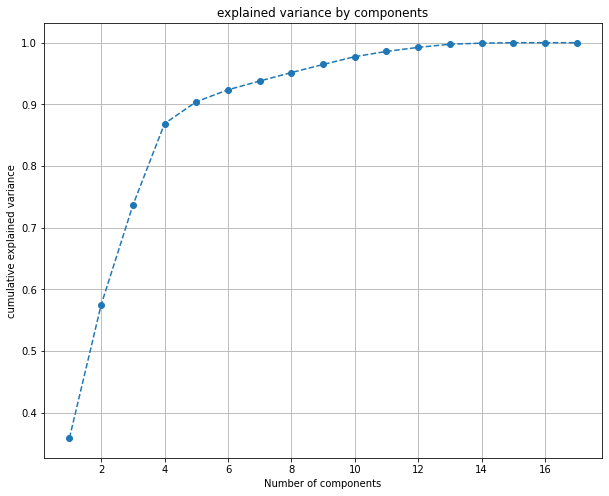

In [122]:
print(pca.explained_variance_) 
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

plt.figure(figsize=(10,8))
plt.plot(range(1, X.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('cumulative explained variance')
plt.grid()



In [123]:
# We keep the first 4 components to get a cumulative variance of 86 per cent;

num_components_pca = 4
pca = PCA(n_components = num_components_pca)
pca.fit(X)



PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [124]:
pca_out = pca.transform(X)
score_pca = pca.transform(X)


In [126]:
print(pca_out.shape, X.shape)

(7926, 4) (7926, 17)


In [136]:
def plot_kmeans_inertia(title, wcss):
  plt.figure(figsize=(10,8))
  plt.plot(range(1,num_clusters), wcss, marker='o', linestyle='--')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.title(title)
  plt.grid()
  plt.show()


In [134]:
# K-Means with PCA outputs
num_clusters = 27
wcss = [] # Sum of squared distances of samples to their closest cluster center.

for i in range(1, num_clusters):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    kmeans.fit(pca_out)
    wcss.append(kmeans.inertia_)

    

In [128]:
# K-Means with whole X (17 columns)
num_clusters = 27
wcss_no_pca = [] # Sum of squared distances of samples to their closest cluster center.

for i in range(1, num_clusters):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    kmeans.fit(X)
    wcss_no_pca.append(kmeans.inertia_)

    

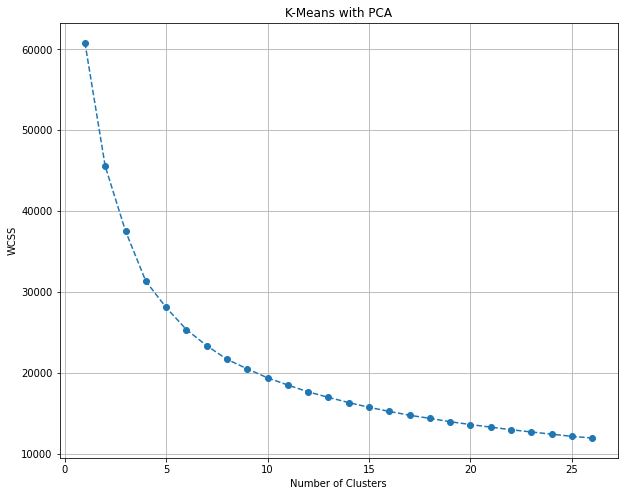

In [137]:
title = 'K-Means with PCA'
plot_kmeans_inertia(title, wcss)

In [ ]:
title = 'K-Means without PCA'
plot_kmeans_inertia(title, wcss_no_pca)

In [ ]:

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_


In [ ]:
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_
